## Getting Started
1. Clone this repository
    ```bash
    git clone https://github.com/Police-Data-Accessibility-Project/data-source-identification.git pdap-data-source-identification
    cd pdap-data-source-identification
    ```
2. Add an annotated dataset JSON file to the `data/` directory
    (see the ## Load Data section of this notebook for the expected JSON file structure)
3. Install [Anaconda](https://docs.anaconda.com/anaconda/install/index.html)
4. Create a conda environment
    ```bash
    conda env create -n PDAP -f environment.yml
    ```
5. Activate the environment (if not already active)
    ```bash
    conda env activate -n PDAP
    ```
6. Run this Jupyter notebook
    ```
    ctrl + shift + alt + Enter
    ```

In [1]:
import os
import nltk
import warnings
import numpy as np
import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

In [2]:
# Set up nltk
nltk.download("punkt")

# Set up seaborn
sea.set_theme()

# Disable all the pesky warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kylenakamura/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Load the data

The data we are about to load is expected to adhere to the following JSON scheme:
```
[
    {
        id: Integer,
        text: String,
        label: String
    }
]
```

Example:
```JSON
[
    {
        "id": 1,
        "text": "https:\/\/alpha.austin.gov\/en\/health-safety\/accountability-and-transparency-in-policing\/police-feedback-and-records\/learn-how-austin-police-departments-policies-are-changing\/ ,   Austin, Texas ,   metro ,   last modified: nan",
        "label": []
    },
    {
        "id": 2,
        "text": "https:\/\/hilliardohio.gov\/hilliard-citizens-police-academy-alumni-show-support\/ ,   Hilliard, Ohio ,   metro ,   last modified: 2020-09-14T13:13:27+00:00",
        "label": []
    }
]
```

In [3]:
base_path = os.getcwd()
file_name = "pdap_annotations_2022_12_12.json"
path = os.path.join(base_path, "data", file_name)

json = pd.read_json(path)
data = pd.DataFrame(json, index=json["id"], columns=["text", "label"])

In [4]:
data.head()

,text,label
id,,
1,https://hilliardohio.gov/hilliard-citizens-pol...,[]
2,https://delcopa.gov/departments/parks/index.ht...,[]
3,http://www.lafayettepolice.us/faq.aspx?qid=133...,[]
4,https://delcopa.gov/council/2016minutes/101216...,[Policies & Contracts]
5,"https://delcopa.gov/covid/wellnessline.html , ...",[]


## Clean the data

In [5]:
# Split the 'text' column into separate columns
data[["url", "location", "location_type", "last_modified"]] = pd.DataFrame(
    data.text.str.split(" ,", expand=True)
)
data.drop("text", inplace=True, axis=1)

In [6]:
# Remove extra text and trailing characters from the 'last_modified' column
data.last_modified = data.last_modified.str.replace("last modified: ", "").str.slice(
    0, 13
)

In [7]:
# Remove extra characters from 'url' column
data.url = (
    data.url.str.replace("https://", "", regex=False)
    .str.replace("http://", "", regex=False)
    .str.replace("www.", "", regex=False)
)

In [8]:
# Remove problematic rows
ignore_patterns = ["delcopa"]
for pattern in ignore_patterns:
    data = data[data.url.str.contains(pattern, regex=True) == False]

In [9]:
# Remove unlabeled rows
data = data[data.label.map(lambda x: len(x)) > 0]

# Remove null rows
data.dropna(inplace=True)

# Remove duplicate rows of urls
data["url"].drop_duplicates(inplace=True)

In [10]:
data.head()

,label,url,location,location_type,last_modified
id,,,,,
8,[Not Criminal Justice Related],mass.gov/doc/coping-with-overdose-fatalities/d...,Massachusetts,state,2020-12-21
9,[Media Bulletins],longbeach.gov/police/press-releases/murder-7-/,"Long Beach, California",metro,2019-06-27
14,[Poor Data Source],lynchburgvapolice.gov/wp-content/uploads/2021/...,"Lynchburg, Virginia",metro,nan
17,"[Geographic, Resources]",southamptontownnypolice.gov/220/geographic-inf...,"Southampton, New York",metro,2020-01-29
19,[Personnel Records],arlingtontx.gov/news/my_arlington_t_x/news_arc...,"Arlington, Texas",metro,2022-02-08


## Run experiments

In [11]:
RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)

### Experiment 1
Use only the "url" and "label" features.
Combine all labels into "non-criminal justice" and "criminal justice" labels to make the classification problem as simple as possible.

In [12]:
# Use only the "url" and "label" features.
df = data.copy()[["url", "label"]]

In [13]:
# Combine all labels into “non-criminal justice” and “criminal justice” labels to make the classification problem as simple as possible.
df["label"] = df["label"].apply(
    lambda labels: "irrelevant"
    if "Not Criminal Justice Related" in labels
    else "relevant"
)

<AxesSubplot: xlabel='label', ylabel='count'>

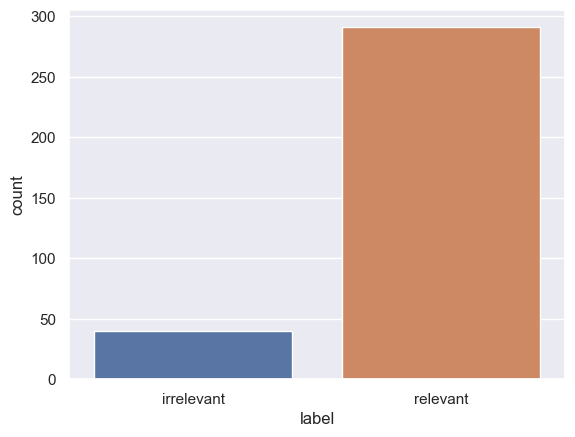

In [14]:
# Visualize the number of observations for each class in our dataset
sea.countplot(x="label", data=df)

In [15]:
# Get tokens for each url
tokenizer = RegexpTokenizer(r"[A-Za-z]+")
df["text_tokenized"] = df["url"].map(lambda _url: tokenizer.tokenize(_url))
df["text_tokenized"] = df["text_tokenized"].apply(
    lambda _tokens_list: [x for x in _tokens_list if len(x) > 1]
)

df.head()

,url,label,text_tokenized
id,,,
8,mass.gov/doc/coping-with-overdose-fatalities/d...,irrelevant,"[mass, gov, doc, coping, with, overdose, fatal..."
9,longbeach.gov/police/press-releases/murder-7-/,relevant,"[longbeach, gov, police, press, releases, murder]"
14,lynchburgvapolice.gov/wp-content/uploads/2021/...,relevant,"[lynchburgvapolice, gov, wp, content, uploads,..."
17,southamptontownnypolice.gov/220/geographic-inf...,relevant,"[southamptontownnypolice, gov, geographic, inf..."
19,arlingtontx.gov/news/my_arlington_t_x/news_arc...,relevant,"[arlingtontx, gov, news, my, arlington, news, ..."


In [16]:
# Get root words from each list of tokens
root_words = SnowballStemmer("english")
df["root_words"] = df["text_tokenized"].map(
    lambda _tokens: [root_words.stem(word) for word in _tokens]
)

df.head()

,url,label,text_tokenized,root_words
id,,,,
8,mass.gov/doc/coping-with-overdose-fatalities/d...,irrelevant,"[mass, gov, doc, coping, with, overdose, fatal...","[mass, gov, doc, cope, with, overdos, fatal, d..."
9,longbeach.gov/police/press-releases/murder-7-/,relevant,"[longbeach, gov, police, press, releases, murder]","[longbeach, gov, polic, press, releas, murder]"
14,lynchburgvapolice.gov/wp-content/uploads/2021/...,relevant,"[lynchburgvapolice, gov, wp, content, uploads,...","[lynchburgvapolic, gov, wp, content, upload, i..."
17,southamptontownnypolice.gov/220/geographic-inf...,relevant,"[southamptontownnypolice, gov, geographic, inf...","[southamptontownnypolic, gov, geograph, inform..."
19,arlingtontx.gov/news/my_arlington_t_x/news_arc...,relevant,"[arlingtontx, gov, news, my, arlington, news, ...","[arlingtontx, gov, news, my, arlington, news, ..."


In [17]:
# Combine the root words into a sentence (space delimited)
df["text_sent"] = df["root_words"].map(lambda _root_words: " ".join(_root_words))

df.head()

,url,label,text_tokenized,root_words,text_sent
id,,,,,
8,mass.gov/doc/coping-with-overdose-fatalities/d...,irrelevant,"[mass, gov, doc, coping, with, overdose, fatal...","[mass, gov, doc, cope, with, overdos, fatal, d...",mass gov doc cope with overdos fatal download
9,longbeach.gov/police/press-releases/murder-7-/,relevant,"[longbeach, gov, police, press, releases, murder]","[longbeach, gov, polic, press, releas, murder]",longbeach gov polic press releas murder
14,lynchburgvapolice.gov/wp-content/uploads/2021/...,relevant,"[lynchburgvapolice, gov, wp, content, uploads,...","[lynchburgvapolic, gov, wp, content, upload, i...",lynchburgvapolic gov wp content upload img jpg
17,southamptontownnypolice.gov/220/geographic-inf...,relevant,"[southamptontownnypolice, gov, geographic, inf...","[southamptontownnypolic, gov, geograph, inform...",southamptontownnypolic gov geograph inform sys...
19,arlingtontx.gov/news/my_arlington_t_x/news_arc...,relevant,"[arlingtontx, gov, news, my, arlington, news, ...","[arlingtontx, gov, news, my, arlington, news, ...",arlingtontx gov news my arlington news archiv ...


In [18]:
# Visualize the data
bad_sites = df[df.label == "irrelevant"]
good_sites = df[df.label == "relevant"]

In [19]:
bad_sites.head()

,url,label,text_tokenized,root_words,text_sent
id,,,,,
8,mass.gov/doc/coping-with-overdose-fatalities/d...,irrelevant,"[mass, gov, doc, coping, with, overdose, fatal...","[mass, gov, doc, cope, with, overdos, fatal, d...",mass gov doc cope with overdos fatal download
74,southamptontownnypolice.gov/faq.aspx?qid=120,irrelevant,"[southamptontownnypolice, gov, faq, aspx, qid]","[southamptontownnypolic, gov, faq, aspx, qid]",southamptontownnypolic gov faq aspx qid
94,lafayettepolice.us/1019/commissions-organizations,irrelevant,"[lafayettepolice, us, commissions, organizations]","[lafayettepolic, us, commiss, organ]",lafayettepolic us commiss organ
114,lafayettepolice.us/1635/learning-adventures-ca...,irrelevant,"[lafayettepolice, us, learning, adventures, ca...","[lafayettepolic, us, learn, adventur, camp, age]",lafayettepolic us learn adventur camp age
134,roundrocktexas.gov/wp-content/uploads/2021/08/...,irrelevant,"[roundrocktexas, gov, wp, content, uploads, ge...","[roundrocktexa, gov, wp, content, upload, gene...",roundrocktexa gov wp content upload general fu...


In [20]:
good_sites.head()

,url,label,text_tokenized,root_words,text_sent
id,,,,,
9,longbeach.gov/police/press-releases/murder-7-/,relevant,"[longbeach, gov, police, press, releases, murder]","[longbeach, gov, polic, press, releas, murder]",longbeach gov polic press releas murder
14,lynchburgvapolice.gov/wp-content/uploads/2021/...,relevant,"[lynchburgvapolice, gov, wp, content, uploads,...","[lynchburgvapolic, gov, wp, content, upload, i...",lynchburgvapolic gov wp content upload img jpg
17,southamptontownnypolice.gov/220/geographic-inf...,relevant,"[southamptontownnypolice, gov, geographic, inf...","[southamptontownnypolic, gov, geograph, inform...",southamptontownnypolic gov geograph inform sys...
19,arlingtontx.gov/news/my_arlington_t_x/news_arc...,relevant,"[arlingtontx, gov, news, my, arlington, news, ...","[arlingtontx, gov, news, my, arlington, news, ...",arlingtontx gov news my arlington news archiv ...
24,police.greenvillesc.gov/1996/getting-here-parking,relevant,"[police, greenvillesc, gov, getting, here, par...","[polic, greenvillesc, gov, get, here, park]",polic greenvillesc gov get here park


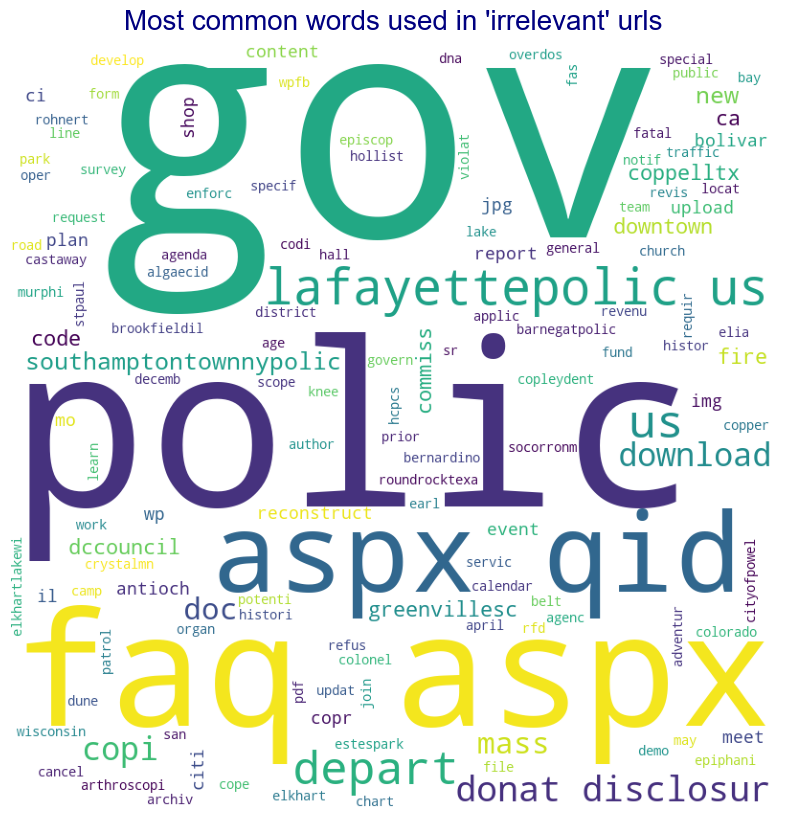

In [21]:
data = bad_sites.text_sent
data.reset_index(drop=True, inplace=True)
text = str(data.values).replace("'", "")

stopwords = set(STOPWORDS).union({"com", "http", "www"})
wordcloud = WordCloud(
    width=800,
    height=800,
    background_color="white",
    stopwords=stopwords,
    max_words=400,
    min_font_size=10,
).generate(text)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.title(
    "Most common words used in 'irrelevant' urls",
    fontdict={"size": 20, "color": "navy", "verticalalignment": "bottom"},
)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

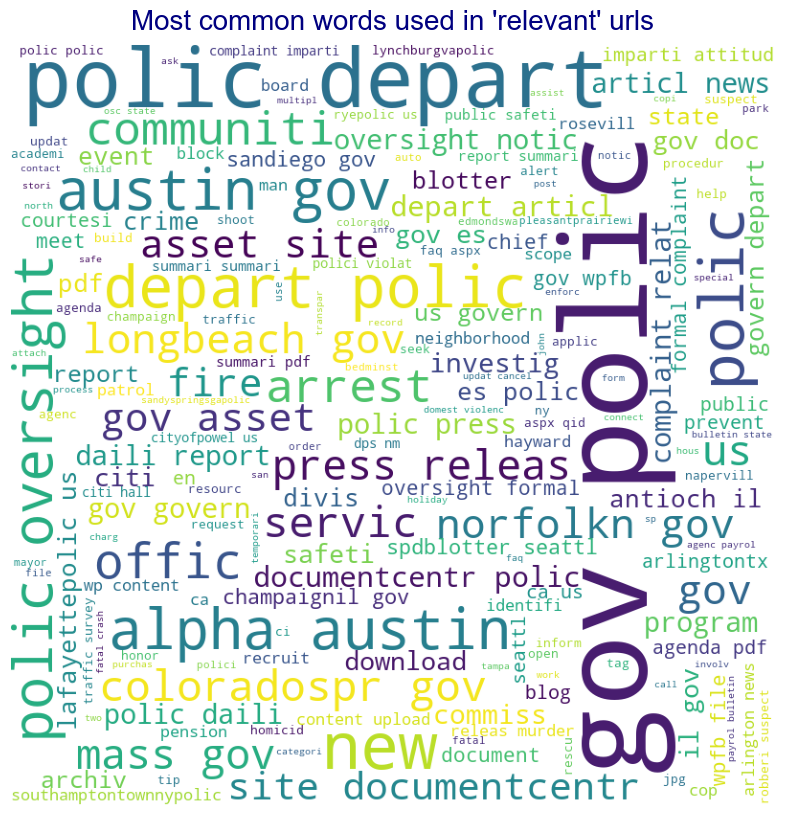

In [22]:
data = good_sites.text_sent
data.reset_index(drop=True, inplace=True)
text = str(data.values).replace("'", "")

stopwords = set(STOPWORDS).union({"com", "http", "www"})
wordcloud = WordCloud(
    width=800,
    height=800,
    background_color="white",
    stopwords=stopwords,
    max_words=400,
    min_font_size=10,
).generate(text)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.title(
    "Most common words used in 'relevant' urls",
    fontdict={"size": 20, "color": "navy", "verticalalignment": "bottom"},
)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

Create a model of the vocabulary in our dataset

In [23]:
c = CountVectorizer()
cv = c.fit_transform(df.text_sent)

In [24]:
print(list(c.vocabulary_)[:10])
print("Vocabulary size:", len(c.get_feature_names_out()))
print("Vocabulary model shape:", cv.shape)

['mass', 'gov', 'doc', 'cope', 'with', 'overdos', 'fatal', 'download', 'longbeach', 'polic']
Vocabulary size: 877
Vocabulary model shape: (331, 877)


Create a model using KNN

In [25]:
x_train, x_test, y_train, y_test = train_test_split(
    cv, df["label"], test_size=0.3, random_state=RANDOM_SEED
)

In [26]:
model = KNeighborsClassifier(n_neighbors=2)
model.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=2)

In [27]:
model.score(x_test, y_test)

0.78

In [28]:
y_pred = model.predict(x_test)

<AxesSubplot: >

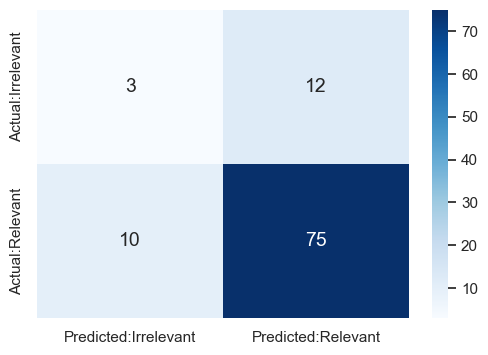

In [29]:
con_mat = pd.DataFrame(
    confusion_matrix(y_pred, y_test),
    columns=["Predicted:Irrelevant", "Predicted:Relevant"],
    index=["Actual:Irrelevant", "Actual:Relevant"],
)
plt.figure(figsize=(6, 4))
sea.heatmap(con_mat, annot=True, fmt="g", cmap="Blues", annot_kws={"size": 14})

In [30]:
print("\nCLASSIFICATION REPORT\n")
print(classification_report(y_pred, y_test, target_names=["irrelevant", "relevant"]))


CLASSIFICATION REPORT

              precision    recall  f1-score   support

  irrelevant       0.23      0.20      0.21        15
    relevant       0.86      0.88      0.87        85

    accuracy                           0.78       100
   macro avg       0.55      0.54      0.54       100
weighted avg       0.77      0.78      0.77       100



Create a model using Logistic Regression

In [31]:
lr = LogisticRegression(max_iter=cv.shape[0])
lr.fit(x_train, y_train)

LogisticRegression(max_iter=331)

In [32]:
lr.score(x_test, y_test)

0.87

In [33]:
y_pred = lr.predict(x_test)

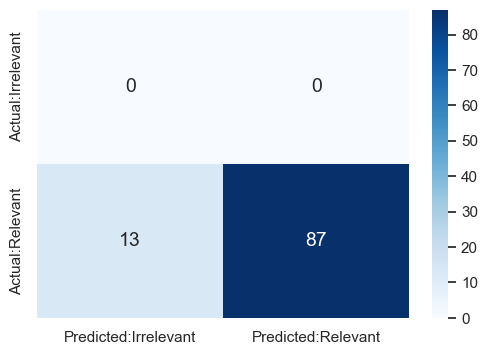

In [34]:
con_mat = pd.DataFrame(
    confusion_matrix(y_pred, y_test),
    columns=["Predicted:Irrelevant", "Predicted:Relevant"],
    index=["Actual:Irrelevant", "Actual:Relevant"],
)
plt.figure(figsize=(6, 4))
_ = sea.heatmap(con_mat, annot=True, fmt="g", cmap="Blues", annot_kws={"size": 14})

In [35]:
print("\nCLASSIFICATION REPORT\n")
print(
    classification_report(
        y_pred, y_test, target_names=["irrelevant", "relevant"], zero_division=0
    )
)


CLASSIFICATION REPORT

              precision    recall  f1-score   support

  irrelevant       0.00      0.00      0.00         0
    relevant       1.00      0.87      0.93       100

    accuracy                           0.87       100
   macro avg       0.50      0.43      0.47       100
weighted avg       1.00      0.87      0.93       100



Combine the whole logistic regression step into one pipeline

In [36]:
x_train, x_test, y_train, y_test = train_test_split(
    df["url"], df["label"], test_size=0.3, random_state=RANDOM_SEED
)

pipeline_ls = make_pipeline(
    CountVectorizer(
        tokenizer=RegexpTokenizer(r"[A-Za-z]+").tokenize, stop_words="english"
    ),
    LogisticRegression(max_iter=cv.shape[0]),
)

pipeline_ls.fit(x_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(stop_words='english',
                                 tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[A-Za-z]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>)),
                ('logisticregression', LogisticRegression(max_iter=331))])

Test the pipeline

In [37]:
pipeline_ls.score(x_test, y_test)

0.87

In [38]:
# Create new tet cases to manually evaluate the model
test_irrelevant = [
    "police.crystalmn.gov/r_e_s_i_d_e_n_t/public_works",
    "youtube.com/watch?v=abcdefg",
]
test_relevant = [
    "police-station.gov/arrest-report.html",
]

pred_irrelevant = pipeline_ls.predict(test_irrelevant)
pred_relevant = pipeline_ls.predict(test_relevant)

print(
    f'Correctly classified {list(pred_irrelevant).count("irrelevant")} of {len(test_irrelevant)} irrelevant urls.'
)
print(
    f'Correctly classified {list(pred_relevant).count("relevant")} of {len(test_relevant)} relevant urls.'
)

Correctly classified 1 of 2 irrelevant urls.
Correctly classified 1 of 1 relevant urls.


### Experiment 2
Same as experiment 1, but with 5 classes.
```
classes = [
    'police_and_public_interactions',
    'info_about_officers',
    'info_about_agencies',
    'agency_resources',
    'jails_and_courts'
]
```

In [39]:
# TODO: Combine labels into the 5 parent classes to conduct experiment 2